# Names, title, etc

In [2]:
from perform_kickstarer_eda import *


ks_data shape: (20632, 68)
Categorical columns: ['country', 'currency', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'category', 'deadline_weekday', 'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday', 'launch_to_deadline', 'launch_to_state_change']
Converted boolean column: staff_pick
Dropped 'state_changed_at_weekday' column
Dropping original column: category
Encoded column: category → 25 features
Dropping original column: deadline_weekday
Encoded column: deadline_weekday → 7 features
Dropping original column: created_at_weekday
Encoded column: created_at_weekday → 7 features
Dropping original column: launched_at_weekday
Encoded column: launched_at_weekday → 7 features
Total categorical columns after encoding: 54


5 features: R² = 0.7201
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'create_to_launch_days', 'launch_to_deadline_days']
10 features: R² = 0.7314
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'create_to_launch_days', 'launch_to_deadline_days', 'created_at_day', 'blurb_len_clean', 'created_at_hr', 'launched_at_day', 'name_len_clean']
15 features: R² = 0.7320
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'create_to_launch_days', 'launch_to_deadline_days', 'created_at_day', 'blurb_len_clean', 'created_at_hr', 'launched_at_day', 'name_len_clean', 'launched_at_hr', 'state_changed_at_day', 'deadline_day', 'created_at_month', 'state_changed_at_hr']
20 features: R² = 0.7344
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'create_to_launch_days', 'launch_to_deadline_days', 'created_at_day', 'blurb_len_clean', 'created_at_hr', 'launched_at_day', 'name_len_clean', 'launched_at_hr

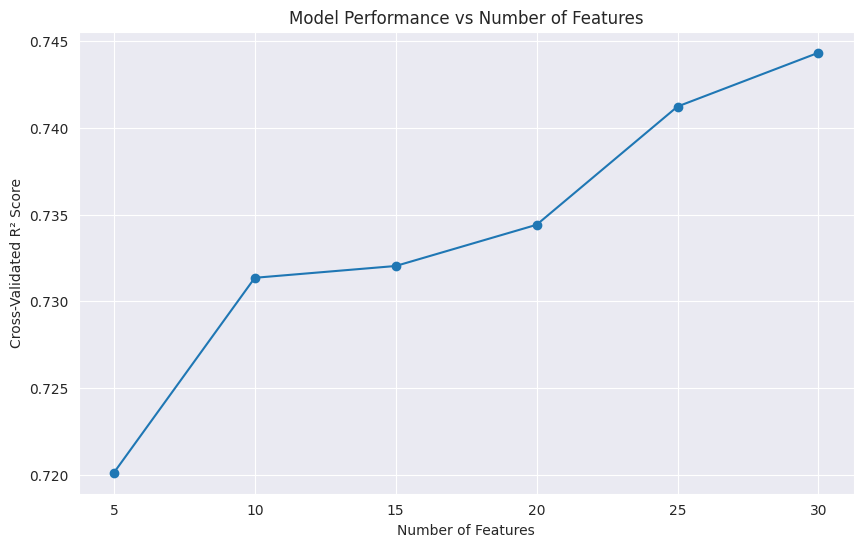


Optimal number of features: 30
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'create_to_launch_days', 'launch_to_deadline_days', 'created_at_day', 'blurb_len_clean', 'created_at_hr', 'launched_at_day', 'name_len_clean', 'launched_at_hr', 'state_changed_at_day', 'deadline_day', 'created_at_month', 'state_changed_at_hr', 'deadline_hr', 'launched_at_month', 'state_changed_at_month', 'category_Gadgets', 'deadline_month', 'category_Software', 'category_Musical', 'category_Hardware', 'category_Apps', 'category_None', 'category_Web', 'created_at_weekday_Friday', 'staff_pick', 'created_at_weekday_Wednesday', 'deadline_weekday_Thursday']

Random Forest selected 30 features: ['backers_count', 'goal', 'launch_to_state_change_days', 'create_to_launch_days', 'launch_to_deadline_days', 'created_at_day', 'blurb_len_clean', 'created_at_hr', 'launched_at_day', 'name_len_clean', 'launched_at_hr', 'state_changed_at_day', 'deadline_day', 'created_at_month', 'state_changed_at

In [3]:
from numpy import ndarray, argsort
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def get_rf_feature_importance(_X_train: DataFrame, _y_train: ndarray, n_features: int = 10) -> list:
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(_X_train, _y_train)

    # Get feature importances
    importances = rf.feature_importances_
    indices = argsort(importances)[::-1]

    # Select top n features
    top_features = _X_train.columns[indices[:n_features]].tolist()
    return top_features, indices


def get_rfe_features(_X_train: DataFrame, _y_train: ndarray, n_features: int = 10) -> list:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(_X_train, _y_train)

    # Get selected features
    selected_features = _X_train.columns[rfe.support_].tolist()
    return selected_features

# Method 3: Statistical feature selection
def get_statistical_features(_X_train: DataFrame, _y_train: ndarray, n_features: int = 10) -> list:
    selector = SelectKBest(score_func=f_regression, k=n_features)
    selector.fit(_X_train, _y_train)

    # Get selected features
    selected_mask = selector.get_support()
    selected_features = _X_train.columns[selected_mask].tolist()
    return selected_features

X = kickstarter.copy()
Y1 = kickstarter['SuccessfulBool']
X = X.drop(columns=['SuccessfulBool'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.2, random_state=42)

# Get ordered features and indices from Random Forest
top_features, importance_indices = get_rf_feature_importance(X_train, y_train, len(X_train.columns))
ranked_features = X_train.columns[importance_indices].tolist()

# Define range of feature counts to test
feature_counts = [5, 10, 15, 20, 25, 30]
if len(ranked_features) < 30:
    feature_counts = list(range(5, len(ranked_features)+1, 5))

# Test different feature counts
cv_scores = []
for n_features in feature_counts:
    if n_features > len(ranked_features):
        continue

    # Select top n features
    selected_features = ranked_features[:n_features]
    X_selected = X_train[selected_features]

    # Evaluate with cross-validation
    scores = cross_val_score(
        RandomForestRegressor(n_estimators=100, random_state=42),
        X_selected, y_train,
        cv=5, scoring='r2'
    )

    cv_scores.append(scores.mean())
    print(f"{n_features} features: R² = {scores.mean():.4f}")
    print(f"Selected features: {selected_features}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(feature_counts[:len(cv_scores)], cv_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated R² Score')
plt.title('Model Performance vs Number of Features')
plt.grid(True)
plt.savefig('feature_selection_curve.png')
plt.show()

# Find the optimal number based on the results
optimal_idx = max(range(len(cv_scores)), key=cv_scores.__getitem__)
optimal_n_features = feature_counts[optimal_idx]
print(f"\nOptimal number of features: {optimal_n_features}")
print(f"Selected features: {ranked_features[:optimal_n_features]}")

# For comparison, also get features using RFE and Statistical methods
rfe_features = get_rfe_features(X_train, y_train, optimal_n_features)
stat_features = get_statistical_features(X_train, y_train, optimal_n_features)

print(f"\nRandom Forest selected {optimal_n_features} features: {ranked_features[:optimal_n_features]}")
print(f"RFE selected {optimal_n_features} features: {rfe_features}")
print(f"Statistical selection selected {optimal_n_features} features: {stat_features}")

# Find common features across all methods
common_features = set(ranked_features[:optimal_n_features]) & set(rfe_features) & set(stat_features)
print(f"\nFeatures selected by all methods: {common_features}")

Test Accuracy: 0.9297

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2902
           1       0.89      0.87      0.88      1224

    accuracy                           0.93      4126
   macro avg       0.92      0.91      0.92      4126
weighted avg       0.93      0.93      0.93      4126


Confusion Matrix:
[[2770  132]
 [ 158 1066]]

Feature Importance:
                         Feature  Importance
0                  backers_count    0.449324
1                           goal    0.135105
27                    staff_pick    0.049413
2    launch_to_state_change_days    0.040351
3          create_to_launch_days    0.028218
4        launch_to_deadline_days    0.022819
5                 created_at_day    0.019600
7                  created_at_hr    0.018729
8                launched_at_day    0.017512
6                blurb_len_clean    0.017391
9                 name_len_clean    0.017019
12                  

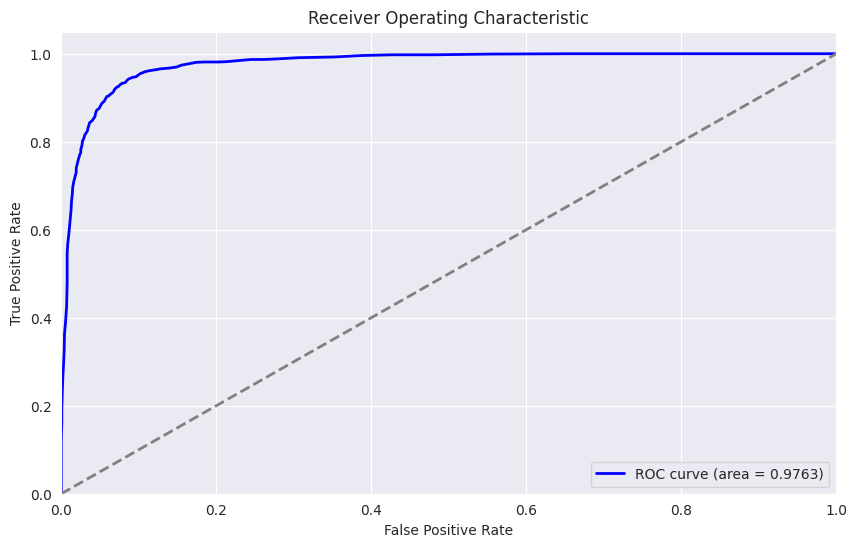

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Get the optimal features we found
optimal_features = ['backers_count', 'goal', 'launch_to_state_change_days', 'create_to_launch_days', 'launch_to_deadline_days', 'created_at_day', 'blurb_len_clean', 'created_at_hr', 'launched_at_day', 'name_len_clean', 'launched_at_hr', 'state_changed_at_day', 'deadline_day', 'created_at_month', 'state_changed_at_hr', 'deadline_hr', 'launched_at_month', 'state_changed_at_month', 'category_Gadgets', 'deadline_month', 'category_Software', 'category_Musical', 'category_Hardware', 'category_Apps', 'category_None', 'category_Web', 'created_at_weekday_Friday', 'staff_pick', 'created_at_weekday_Wednesday', 'deadline_weekday_Thursday']

# Train the model using optimal features
X_train_optimal = X_train[optimal_features]
X_test_optimal = X_test[optimal_features]

# Since 'SuccessfulBool' is binary, use RandomForestClassifier instead of Regressor
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=None,  # You can tune this parameter
    min_samples_split=2,
    min_samples_leaf=1
)

# Train the model
rf_model.fit(X_train_optimal, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_optimal)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Feature importance of the final model
feature_importance = rf_model.feature_importances_
importance_df = DataFrame({
    'Feature': optimal_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# Calculate cross-validation score for more robust evaluation
cv_scores = cross_val_score(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X[optimal_features], Y1,
    cv=5, scoring='accuracy'
)
print(f"\nCross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Optional: Plot ROC curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Get probability predictions
y_pred_proba = rf_model.predict_proba(X_test_optimal)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()